In [1]:
import pandas as pd
from collections import deque
import random
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("Data.csv")
data.head()

,Date,Open,High,Low,Close,Volume
0,1998-10-23 00:00:00+05:30,14.615395,15.427776,14.317274,15.129654,17665237
1,1998-10-26 00:00:00+05:30,15.278712,16.344496,15.278712,16.187983,11531300
2,1998-10-27 00:00:00+05:30,16.314686,17.484813,15.696084,17.112160,21477780
3,1998-10-28 00:00:00+05:30,16.918385,17.693501,16.322142,16.456297,18610023
4,1998-10-29 00:00:00+05:30,16.351948,17.104705,15.964392,16.873661,15478216


In [3]:
tf.__version__

'1.15.0'

In [4]:
data.shape

(6278, 6)

In [5]:
df= data.copy()
name = 'Q-learning agent'
close = df['Close']

class Agent:
    def __init__(self, state_size, window_size, trend, skip, batch_size):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.action_size = 3
        self.batch_size = batch_size
        self.memory = deque(maxlen = 1000)
        self.inventory = []

        self.gamma = 0.95
        self.epsilon = 0.5
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.999

        tf.reset_default_graph()
        self.sess = tf.InteractiveSession()
        self.X = tf.placeholder(tf.float32, [None, self.state_size])
        self.Y = tf.placeholder(tf.float32, [None, self.action_size])
        feed = tf.layers.dense(self.X, 256, activation = tf.nn.relu)
        self.logits = tf.layers.dense(feed, self.action_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.GradientDescentOptimizer(1e-5).minimize(
            self.cost
        )
        self.sess.run(tf.global_variables_initializer())

    def act(self, state):
        if random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        return np.argmax(
            self.sess.run(self.logits, feed_dict = {self.X: state})[0]
        )
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])

    def replay(self, batch_size):
        mini_batch = []
        l = len(self.memory)
        for i in range(l - batch_size, l):
            mini_batch.append(self.memory[i])
        replay_size = len(mini_batch)
        X = np.empty((replay_size, self.state_size))
        Y = np.empty((replay_size, self.action_size))
        states = np.array([a[0][0] for a in mini_batch])
        new_states = np.array([a[3][0] for a in mini_batch])
        Q = self.sess.run(self.logits, feed_dict = {self.X: states})
        Q_new = self.sess.run(self.logits, feed_dict = {self.X: new_states})
        for i in range(len(mini_batch)):
            state, action, reward, next_state, done = mini_batch[i]
            target = Q[i]
            target[action] = reward
            if not done:
                target[action] += self.gamma * np.amax(Q_new[i])
            X[i] = state
            Y[i] = target
        cost, _ = self.sess.run(
            [self.cost, self.optimizer], feed_dict = {self.X: X, self.Y: Y}
        )
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        return cost
    
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
                
                
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
        
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.act(state)
                next_state = self.get_state(t + 1)
                
                if action == 1 and starting_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]
                
                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                    
                invest = ((starting_money - initial_money) / initial_money)
                self.memory.append((state, action, invest, 
                                    next_state, starting_money < initial_money))
                state = next_state
                batch_size = min(self.batch_size, len(self.memory))
                cost = self.replay(batch_size)
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [6]:
close = df.Close.values.tolist()
initial_money = 1_00_000
window_size = 60
skip = 1
batch_size = 32
agent = Agent(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)
agent.train(iterations = 1000, checkpoint = 10, initial_money = initial_money)




Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.


epoch: 10, total rewards: 32346.347754.3, cost: 0.854881, total money: 117094.336706
epoch: 20, total rewards: 9860.848979.3, cost: 0.553683, total money: 95647.287944
epoch: 30, total rewards: 26486.782185.3, cost: 0.218086, total money: 116540.513142
epoch: 40, total rewards: 15285.091039.3, cost: 0.151096, total money: 102241.432958
epoch: 50, total rewards: 8438.232934.3, cost: 0.132314, total money: 99148.582910
epoch: 60, total rewards: 3244.745206.3, cost: 0.594007, total money: 97063.595181
epoch: 70, total rewards: 8394.775694.3, cost: 0.065679, total money: 97860.908445
epoch: 80, total rewards: 7220.272487.3, cost: 0.056784, total money: 93007.715602
epoch: 90, total rewards: 5652.659010.3, cost: 0.039972, total money: 93872.253675
epoch: 100, total rewards: 8586.621748.3, cost: 0.048432, total money: 98043.754499
epoch: 110, total rewards: 6

In [7]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 59: buy 1 unit at price 33.449207, total balance 99966.550793
day 74, sell 1 unit at price 28.917767, investment -13.547229 %, total balance 99995.468559,
day 139: buy 1 unit at price 22.619953, total balance 99972.848606
day 140: buy 1 unit at price 24.162731, total balance 99948.685875
day 157, sell 1 unit at price 26.316656, investment 16.342664 %, total balance 99975.002531,
day 169: buy 1 unit at price 29.428869, total balance 99945.573662
day 172: buy 1 unit at price 33.298698, total balance 99912.274963
day 184: buy 1 unit at price 36.365772, total balance 99875.909191
day 193, sell 1 unit at price 41.326130, investment 71.032528 %, total balance 99917.235321,
day 195: buy 1 unit at price 40.659695, total balance 99876.575626
day 207: buy 1 unit at price 40.038704, total balance 99836.536922
day 208: buy 1 unit at price 40.197746, total balance 99796.339176
day 209: buy 1 unit at price 39.243538, total balance 99757.095638
day 221, sell 1 unit at price 48.013130, investment 

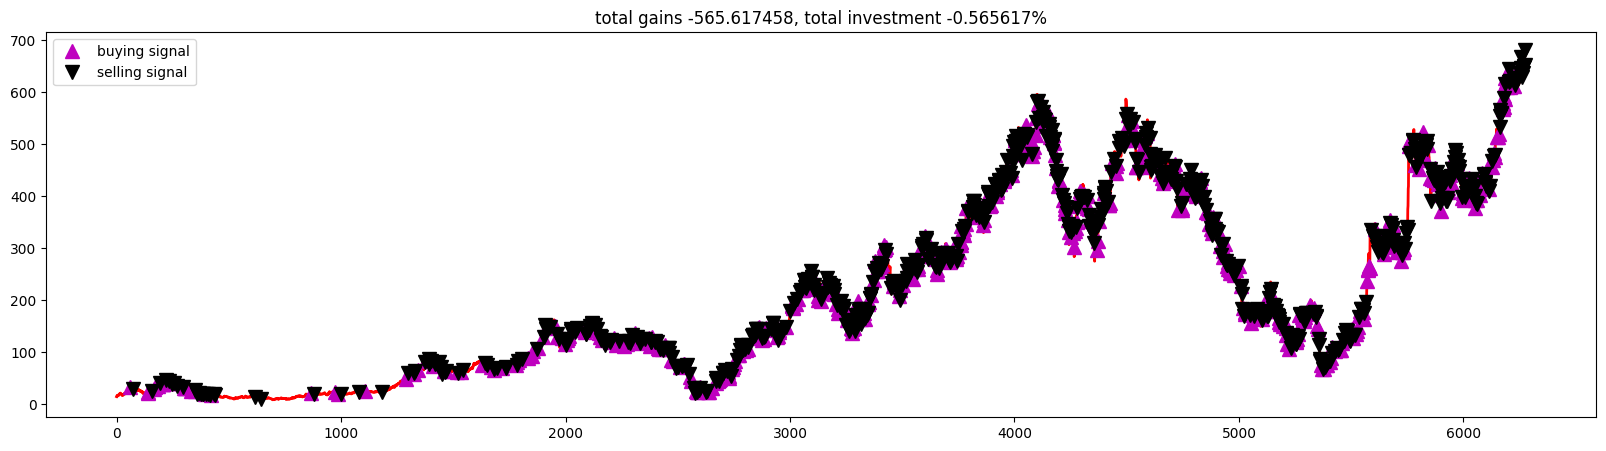

In [8]:
fig = plt.figure(figsize = (20,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()